## Output of fine-tuning as two units - angle converted into x+iy

### Also, changed the training and val sets to set41/51

In [1]:
from scipy.io import loadmat
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torchvision
import torchvision.models as models
import time
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
torch.cuda.is_available()

False

In [3]:
# Test torchvision.datasets.ImageFolder to see how it handles filename and labels

full_dataset = torchvision.datasets.ImageFolder(
    root="data/classifier_finetune",
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                   std=[0.229, 0.224, 0.225])])
)

full_dataset.imgs[:10]

[('data/classifier_finetune/set2/ang_000/img_ind_01.png', 0),
 ('data/classifier_finetune/set2/ang_000/img_ind_02.png', 0),
 ('data/classifier_finetune/set2/ang_000/img_ind_03.png', 0),
 ('data/classifier_finetune/set2/ang_000/img_ind_04.png', 0),
 ('data/classifier_finetune/set2/ang_000/img_ind_05.png', 0),
 ('data/classifier_finetune/set2/ang_000/img_ind_06.png', 0),
 ('data/classifier_finetune/set2/ang_000/img_ind_07.png', 0),
 ('data/classifier_finetune/set2/ang_000/img_ind_08.png', 0),
 ('data/classifier_finetune/set2/ang_000/img_ind_09.png', 0),
 ('data/classifier_finetune/set2/ang_000/img_ind_10.png', 0)]

## Extract orientation (degree) and convert to x+iy from the file name

The default behavior of `torchvision.datasets.ImageFolder` does not extract the angle properly from the filename. 
Therefore, we will have to write a derived class based on `ImageFolder` to do the label extraction ourselves. 

Interestingly, the `ImageFolder` class populates a variable `self.imgs` (which is equivalent to `self.samples` in its own base class) that retains the original file names, which comes handy in terms of angle extraction. 

In the cell below, we implement the derived class to do exactly that.

In [4]:
# regular expression
import re

class ImageFolderWithDegreeExtractor(torchvision.datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None,
                 loader=torchvision.datasets.folder.default_loader):
        super().__init__(root, transform=transform, 
                         target_transform=target_transform,
                         loader=loader)        
        self.angle_extractor = re.compile(r'ang_(\d{3})')
        
    def extract_angle(self, filename):
        angle = int(self.angle_extractor.search(filename).group(1), base=10)
        angle = angle*2#both x,y would be ranged from -1 to 1; 
        return np.array([np.cos(angle/180*np.pi), np.sin(angle/180*np.pi)], dtype=np.float32)
        
    def __getitem__(self, index):
        """Override the __getitem__ method, so that we can return the
        extracted angle (from the filename) as the proper target, instead
        of the default target (which is wrong.)"""
        sample, target = super().__getitem__(index)
        
        return sample, self.extract_angle(self.imgs[index][0])

In [319]:
# now, testing our shiny new ImageFolderWithDegreeExtractor class, to see if it can extract
# the class label (degree) correctly or not.

full_dataset = ImageFolderWithDegreeExtractor(
    root="data/set51_val/",
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                   std=[0.229, 0.224, 0.225])])
)

print(full_dataset.imgs[5000])
sample, target = full_dataset[5000]
print("target:", target)

('data/set51_val/ang_041/img_ind_081.png', 41)
target: [0.7547096 0.656059 ]


In [323]:
np.arctan2(0.656059,0.7547096)/np.pi*180

40.99999800298753

In [6]:
device = torch.device('cpu:0')
# device = torch.device('cuda:0')

In [11]:
# for finetuning
def train_model(model, dataloaders, optimizer, num_epochs=25):
    since = time.time()
    loss_fn = nn.MSELoss()#MSE(L2)loss instead if circular2units for orientation;nn.CrossEntropyLoss()

    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            #running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    # print(outputs)
                    loss = loss_fn(outputs, labels)
                    
                    # compute accuracy
                    # values, indices = torch.max(outputs, dim=1)
                    # accuracy = torch.mean((indices == labels).float())
                    
                    # also include L1 regularization of layer 6 weights
                    # lambda may be fitted instead...
                    # print(f"Objective loss: {loss.item()}")
                    # loss = loss + torch.sum(torch.abs(model.state_dict()['conv_pool.4.weight'])) * 0.1
                    # print(f"Total loss (with regularization): {loss.item()}")

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                print("Mini-batch {}, loss: {}".format(i, loss.item()))
                running_loss += loss.item() * inputs.size(0)#sum loss
                # running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            #epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss_history

In [8]:
# construct a new model reusing certain layers from AlexNet.
from utils_hdf5 import SlimAlexNet
#example: slim_net = SlimAlexNet(alexnet, max_pool_layer_index=1, dropout_ratio=dropout_rate, last_layer_num_params=2)

# class Flatten(nn.Module):
#     def __init__(self, n):
#         super().__init__()
#         self.n = n
        
#     def forward(self, x):
#         return x.view(-1, self.n)

### utils_hdf5.SlimAlexNet is flexible in selecting maxpool layer and last_layer_num_params
# class SlimAlexNet(nn.Module):
#     def __init__(self, alexnet):
#         """Construct a slim versino of AlexNet by only reusing the first a few layers.
#         The last layer maps the output of the MaxPool2D layer to 180 classes corresponding
#         to 180 degrees.
#         """
#         super().__init__()
#         # extract the first a few layers, then combine it with two extra layers
#         # (1) a flattening layer that returns an 1d array
#         # (2) a linear layer 
#         self.conv_pool = nn.Sequential(*(
#             list(alexnet.features.children())[:3] +
#             [Flatten(64 * 27 * 27), nn.Dropout(), nn.Linear(64 * 27 * 27, 180)]
#         ))
        
#     def forward(self, x):
#         return self.conv_pool(x)

In [12]:
# load training orientation images (need to make sure the same order as in .mat is maintained)
train_path = 'data/set41'
val_path = 'data/set41_val'

train_dataset = ImageFolderWithDegreeExtractor(
    root=train_path,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                               std=[0.229, 0.224, 0.225])])
)
val_dataset = ImageFolderWithDegreeExtractor(
    root=val_path,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                               std=[0.229, 0.224, 0.225])])
)
# prepare for data loader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2048,
    num_workers=0,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=2048,
    num_workers=0,
    shuffle=True
)
dataloaders_dict = {
    'train': train_loader,
    'val': val_loader
}

# load the pretrained alexnet
alexnet = models.alexnet(pretrained = True)

# freeze the parameters of all layers
for param in alexnet.parameters():
    param.requires_grad = False #fix weights

slim_net = SlimAlexNet(alexnet,max_pool_layer_index=1, dropout_ratio=.5, last_layer_num_params=2)

slim_net.to(device)
print(slim_net)    
# the parameters would be finetuned
params_to_update = slim_net.parameters()

print("Params to learn:")
for name, param in slim_net.named_parameters():
    if param.requires_grad == True:
        print("\t", name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-4) #, momentum=0.9)
#optimizer_ft = optim.SGD(params_to_update, lr=1e-10, momentum=0.9)

# Train and evaluate
model_ft, val_loss_history = train_model(slim_net, dataloaders_dict, optimizer_ft, num_epochs=10)
print(val_loss_history)

# ... after training, save your model
torch.save(model_ft.state_dict(), 'set41_finetune_circular2units.pt')

SlimAlexNet(
  (conv_pool): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten()
    (4): Dropout(p=0.5)
    (5): Linear(in_features=46656, out_features=2, bias=True)
  )
)
Params to learn:
	 conv_pool.5.weight
	 conv_pool.5.bias
Epoch 0/9
----------
Mini-batch 0, loss: 1.507124662399292
Mini-batch 1, loss: 6.1183390617370605
Mini-batch 2, loss: 2.003086566925049
Mini-batch 3, loss: 3.2423651218414307
Mini-batch 4, loss: 3.4610328674316406
Mini-batch 5, loss: 2.7522032260894775
Mini-batch 6, loss: 1.6249574422836304
Mini-batch 7, loss: 1.632328987121582
Mini-batch 8, loss: 2.3822760581970215
Mini-batch 9, loss: 2.4207403659820557
Mini-batch 10, loss: 1.626447081565857
Mini-batch 11, loss: 1.0465167760849
Mini-batch 12, loss: 1.4974268674850464
Mini-batch 13, loss: 2.108055353164673
Mini-batch 14, loss: 1.8236085176467896
Mini-b

Mini-batch 4, loss: 0.7314922213554382
Mini-batch 5, loss: 0.7176735401153564
Mini-batch 6, loss: 0.7172490954399109
Mini-batch 7, loss: 0.7105772495269775
Mini-batch 8, loss: 0.710321307182312
Mini-batch 9, loss: 0.7159391641616821
Mini-batch 10, loss: 0.7348371148109436
Mini-batch 11, loss: 0.7408905029296875
Mini-batch 12, loss: 0.7240352034568787
Mini-batch 13, loss: 0.6942562460899353
Mini-batch 14, loss: 0.7095490097999573
Mini-batch 15, loss: 0.7318181991577148
Mini-batch 16, loss: 0.7131668329238892
Mini-batch 17, loss: 0.7213000655174255
Mini-batch 18, loss: 0.7181065678596497
Mini-batch 19, loss: 0.6978359818458557
Mini-batch 20, loss: 0.7021921873092651
Mini-batch 21, loss: 0.6978908181190491
Mini-batch 22, loss: 0.7178174257278442
Mini-batch 23, loss: 0.7058427929878235
Mini-batch 24, loss: 0.6857133507728577
Mini-batch 25, loss: 0.6836254596710205
Mini-batch 26, loss: 0.6770227551460266
Mini-batch 27, loss: 0.7121391892433167
Mini-batch 28, loss: 0.6750538945198059
Mini-ba

Mini-batch 17, loss: 0.48174813389778137
Mini-batch 18, loss: 0.504845380783081
Mini-batch 19, loss: 0.4957796037197113
Mini-batch 20, loss: 0.49136775732040405
Mini-batch 21, loss: 0.47293999791145325
Mini-batch 22, loss: 0.48969122767448425
Mini-batch 23, loss: 0.4861070513725281
Mini-batch 24, loss: 0.47847339510917664
Mini-batch 25, loss: 0.45447319746017456
Mini-batch 26, loss: 0.47182342410087585
Mini-batch 27, loss: 0.48220327496528625
Mini-batch 28, loss: 0.4792616069316864
Mini-batch 29, loss: 0.45310473442077637
Mini-batch 30, loss: 0.4725453555583954
Mini-batch 31, loss: 0.46032243967056274
Mini-batch 32, loss: 0.4636627435684204
Mini-batch 33, loss: 0.45554012060165405
Mini-batch 34, loss: 0.4318602979183197
Mini-batch 35, loss: 0.4597972631454468
train Loss: 0.4844
Mini-batch 0, loss: 0.11412396281957626
Mini-batch 1, loss: 0.11651486903429031
Mini-batch 2, loss: 0.11844838410615921
Mini-batch 3, loss: 0.1125447228550911
Mini-batch 4, loss: 0.11963348090648651
Mini-batch 5

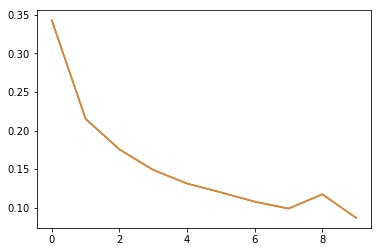

In [19]:
plt.plot(val_loss_history)
plt.show()

## Load the fine-tuned model and let it do some psychophysics 

In [351]:
# load the pretrained alexnet
alexnet = models.alexnet(pretrained = True)

# free the parameters of all layers
for param in alexnet.parameters():
    param.requires_grad = False #fix weights

slim_net = SlimAlexNet(alexnet,max_pool_layer_index=1, dropout_ratio=.5, last_layer_num_params=2)
slim_net.to(device)
print(slim_net)    
# 03312019 finetune set41 with multiple levels of external uncertainty
# version1 when target orientation ranges from 0 to 180, thus x:-1~1, but y:0~1
# version2 multiply target orientation by 2, so both x,y:-1~1 - predicted needs to be divided by 2
slim_net.load_state_dict(torch.load('set41_finetune_circular2units_2.pt', map_location='cpu'))
# version2.1 'set41_finetune_circular2units_2.1.pt', same process repeated for another time
# slim_net.load_state_dict(torch.load('set41_finetune_circular2units_2.1.pt', map_location='cpu'))
# set 51, with parameters [centerFreq = 0; freqSigma = 10; orientBW = .5], very low noise, 
# to teach the network about orientation
# slim_net.load_state_dict(torch.load('set51_finetune_circular2units.pt', map_location='cpu'))

SlimAlexNet(
  (conv_pool): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten()
    (4): Dropout(p=0.5)
    (5): Linear(in_features=46656, out_features=2, bias=True)
  )
)


In [352]:
from PIL import Image
import torchvision.transforms as transforms

preprocessFn = transforms.Compose([transforms.Scale(256), 
                                   transforms.CenterCrop(224), 
                                   transforms.ToTensor(), 
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])

slim_net.eval()
# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
ang_ind = 20
image = Image.open('data/set11/ang_' + '%03d'%ang_ind + '/img_ind_19.png').convert('RGB')
inputVar =  Variable(preprocessFn(image).unsqueeze(0))
predictions = slim_net(inputVar)
p = predictions.detach().numpy().flatten()
if p[1]>0:
    print([p, np.arctan2(p[1],p[0])/np.pi*180/2])#need to divide by 2 for original angle
else:
    print([p, (np.arctan2(p[1],p[0])/np.pi*180+360)/2])

/Users/cqiu/anaconda/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


[array([0.7475953, 0.6797084], dtype=float32), 21.138445103759814]


In [353]:
# predictions for the low noise level images
from time import time
t1 = time()
thetah_mean = np.zeros([180,200])
p0 = np.zeros([180,200])
p1 = np.zeros([180,200])
for ang_ind in range(0,180):
    total_ind = 0
    for set_ind in [2, 3, 4, 5]:
        for img_ind in range(0,50): 
            image = Image.open('data/set' + '%d'%set_ind + '/ang_' + '%03d'%ang_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png').convert('RGB')
            inputVar =  Variable(preprocessFn(image).unsqueeze(0))
            predictions = slim_net(inputVar)
            # convert to angle estimate
            p = predictions.detach().numpy().flatten()
            if p[1]>0:
                estang = np.arctan2(p[1],p[0])/np.pi*180/2 #need to divide by 2 for original angle
            else:
                estang = (np.arctan2(p[1],p[0])/np.pi*180+360)/2
            thetah_mean[ang_ind, total_ind] = estang
            p0[ang_ind, total_ind] = p[0]
            p1[ang_ind, total_ind] = p[1]
            total_ind = total_ind + 1
print(time()-t1)
# about 8 min in total

514.3426251411438


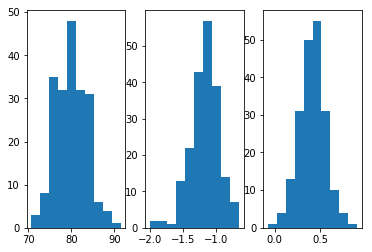

In [354]:
test_angle = 80
plt.subplot(1,3,1); plt.hist(thetah_mean[test_angle,:])
plt.subplot(1,3,2); plt.hist(p0[test_angle,:])
plt.subplot(1,3,3); plt.hist(p1[test_angle,:])
plt.show()

In [355]:
# predictions for the high noise images
t1 = time()
thetah_mean_highnoise = np.zeros([180,200])
for ang_ind in range(0,180):
    total_ind = 0
    for set_ind in [11, 12, 13, 14]:
        for img_ind in range(0,50): 
            image = Image.open('data/set' + '%d'%set_ind + '/ang_' + '%03d'%ang_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png').convert('RGB')
            inputVar =  Variable(preprocessFn(image).unsqueeze(0))
            predictions = slim_net(inputVar)
            # convert to angle estimate
            p = predictions.detach().numpy().flatten()
            if p[1]>0:
                estang = np.arctan2(p[1],p[0])/np.pi*180/2 #need to divide by 2 for original angle
            else:
                estang = (np.arctan2(p[1],p[0])/np.pi*180+360)/2
            thetah_mean_highnoise[ang_ind, total_ind] = estang
            total_ind = total_ind + 1
print(time()-t1)

534.2738809585571


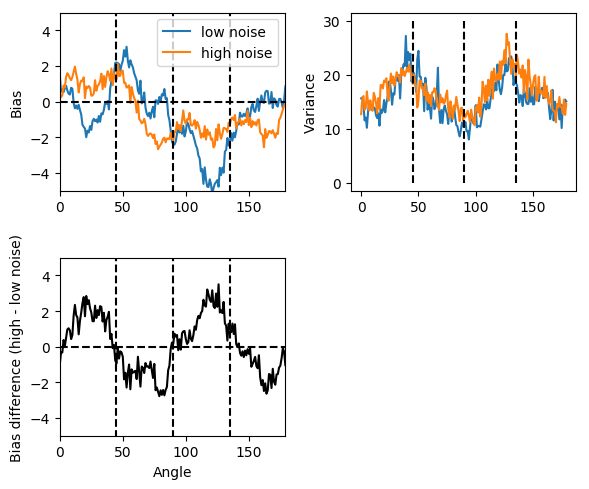

In [357]:
from scipy.stats import circmean
from scipy.stats import circvar
plt.figure(num=None, figsize=(6,5), dpi=100, facecolor='w', edgecolor='k')
x = np.array(range(0,180))
# or thetah_argmax
y_lownoise = circmean(thetah_mean, high=180, low=0, axis=1)-x 
e_lownoise = circvar(thetah_mean, high=180, low=0, axis=1)

y_highnoise = circmean(thetah_mean_highnoise, high=180, low=0, axis=1)-x 
e_highnoise = circvar(thetah_mean_highnoise, high=180, low=0, axis=1)

plt.subplot(2,2,1)
# plt.plot(x, y_lownoise, label='low noise')
plt.plot(x, np.where(y_lownoise < 90, y_lownoise, y_lownoise-180), label='low noise')#circular difference
# plt.plot(x, y_highnoise, label='high noise')
plt.plot(x, np.where(y_highnoise < 90, y_highnoise, y_highnoise-180), label='high noise')#circular difference
plt.plot([0,179],[0,0],'k--'); 
plt.plot([45,45],[-7,7],'k--'); 
plt.plot([90,90],[-7,7],'k--'); 
plt.plot([135,135],[-7,7],'k--'); 
plt.legend(); plt.xlim([0, 179]); plt.ylim([-5, 5]); 
plt.ylabel('Bias')
plt.subplot(2,2,2)
plt.plot(x, e_lownoise); plt.plot(x, e_highnoise); plt.ylabel('Variance')
plt.plot([45,45],[0,30],'k--'); 
plt.plot([90,90],[0,30],'k--'); 
plt.plot([135,135],[0,30],'k--'); #plt.xlim([0, 179]); plt.ylim([0, 30]); 

# difference
plt.subplot(2,2,3)
bias_diff = np.where(y_highnoise < 90, y_highnoise, y_highnoise-180)-np.where(y_lownoise < 90, y_lownoise, y_lownoise-180)
plt.plot(x, bias_diff,'k'); #plt.plot(x, y_lownoise)
plt.plot([0,179],[0,0],'k--'); #plt.grid(True)
plt.plot([45,45],[-7,7],'k--'); 
plt.plot([90,90],[-7,7],'k--'); 
plt.plot([135,135],[-7,7],'k--'); 
plt.xlim([0, 179]); plt.ylim([-5, 5]); 
plt.ylabel('Bias difference (high - low noise)'); plt.xlabel('Angle'); 
plt.tight_layout(); plt.show()

In [348]:
# what about the residual biases in set41/51_val? Or bias for various levels of noise
# it seems like if there is anything, 
# attraction for low noise & repultion for high noise (overall, repulsion)
t1 = time()
set_ind = 41 
thetah_mean_val = np.zeros([180,120])
p0 = np.zeros([180,120])
p1 = np.zeros([180,120])
mse_tmp = 0
for ang_ind in range(0,180):
    total_ind = 0
    for img_ind in range(0,120,1):#range(0,400,40): 
        image = Image.open('data/set' + '%d'%set_ind + '/ang_' + '%03d'%ang_ind + '/img_ind_' + '%03d'%(img_ind+1) + '.png').convert('RGB')
        inputVar =  Variable(preprocessFn(image).unsqueeze(0))
        predictions = slim_net(inputVar)
        # convert to angle estimate
        p = predictions.detach().numpy().flatten()
        # true output based on ang_ind
        p_target = np.array([np.cos(ang_ind*2/180*np.pi), np.sin(ang_ind*2/180*np.pi)], dtype=np.float32)
        mse_tmp += np.mean((p_target-p)**2)
        if p[1]>0:
            estang = np.arctan2(p[1],p[0])/np.pi*180/2 #need to divide by 2 for original angle
        else:
            estang = (np.arctan2(p[1],p[0])/np.pi*180+360)/2
        thetah_mean_val[ang_ind, total_ind] = estang
        p0[ang_ind, total_ind] = p[0]
        p1[ang_ind, total_ind] = p[1]
        total_ind = total_ind + 1
print(time()-t1)

293.73636984825134


In [349]:
mse_tmp/(180*120)

0.05215616231758185

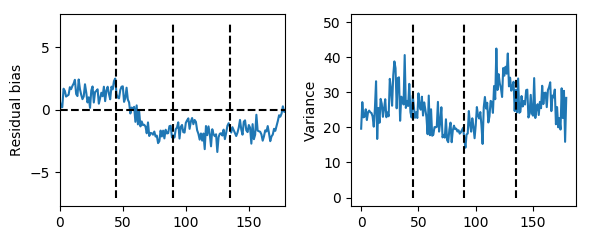

In [350]:
x = np.array(range(0,180))
# or thetah_argmax
y_val = circmean(thetah_mean_val, high=180, low=0, axis=1)-x 
e_val = circvar(thetah_mean_val, high=180, low=0, axis=1)
plt.figure(num=None, figsize=(6,2.5), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.plot(x, np.where(y_val < 90, y_val, y_val-180))#circular difference
plt.plot([0,179],[0,0],'k--'); 
plt.plot([45,45],[-7,7],'k--'); 
plt.plot([90,90],[-7,7],'k--'); 
plt.plot([135,135],[-7,7],'k--'); 
plt.xlim([0, 179]); #plt.ylim([-5,5]); 
plt.ylabel('Residual bias'); #plt.tight_layout(); plt.show()

plt.subplot(1,2,2)
plt.plot(x, e_val); 
plt.plot([45,45],[0,50],'k--'); 
plt.plot([90,90],[0,50],'k--'); 
plt.plot([135,135],[0,50],'k--'); 
plt.ylabel('Variance'); #plt.xlim([0, 179]); plt.ylim([0, 50]); 
plt.tight_layout(); plt.show()